### Necessary Imports

In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.tensorboard.writer import SummaryWriter
from colorama import Fore, Style
from pypesq import pesq
import soundfile as sf
from IPython.display import display
from IPython.display import Audio
import time

parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)
from data import get_dataloader, dataloader_sampler, visualize_spectrogram

plt.style.use("default")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

Loading the data and visualizing samples

In [2]:
speech_dir = os.path.abspath("../data/speech_files")
speech_files = glob.glob(os.path.join(speech_dir, "*.wav"))
train_dataloader, val_dataloader = get_dataloader(speech_dir, batch_size=batch_size)

In [3]:
dataloader_sampler(train_dataloader)

Sample 1 - Data shape: torch.Size([64, 1, 128, 256]), Target shape: torch.Size([64, 1, 128, 256])
Sample 2 - Data shape: torch.Size([64, 1, 128, 256]), Target shape: torch.Size([64, 1, 128, 256])
Sample 3 - Data shape: torch.Size([64, 1, 128, 256]), Target shape: torch.Size([64, 1, 128, 256])
Sample 4 - Data shape: torch.Size([64, 1, 128, 256]), Target shape: torch.Size([64, 1, 128, 256])


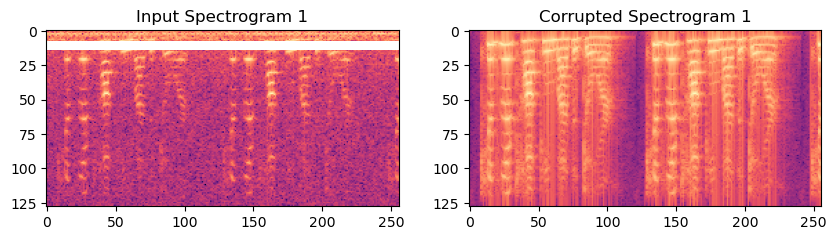

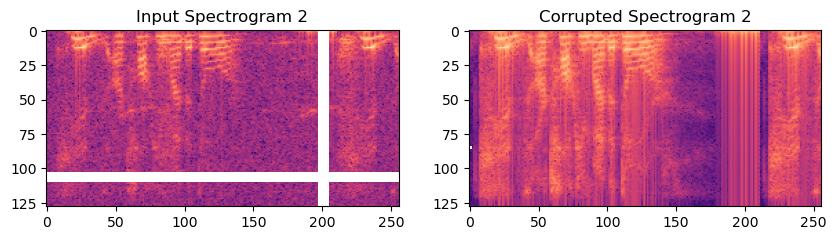

In [4]:
visualize_spectrogram(train_dataloader, num_samples=2)

### Initialize the model

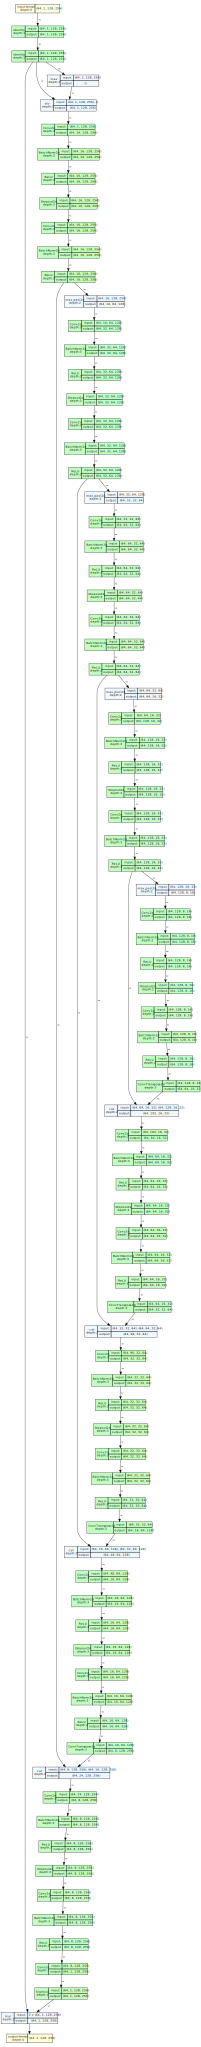

In [5]:
import torch
from src import CustomUNet
import graphviz
from torchview import draw_graph

graphviz.set_jupyter_format("svg")

# Initialize the model
model = CustomUNet(input_shape=(1, 128, 256), num_classes=1)

model_graph = draw_graph(model, input_size=(batch_size, 1, 128, 256), device="meta")
model_graph.fill_visual_graph()
model_graph.visual_graph

### Training and validation

In [6]:
# Initialize the model
model = CustomUNet(input_shape=(1, 128, 256), num_classes=1)
model.to(device)

# Define custom loss function
class SignalEnhancementLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_true, y_pred):
        mae = torch.abs(y_true - y_pred)
        speech_loss = 2 * torch.abs(y_true**2 - y_pred * y_true)
        loss = torch.mean(mae, dim=-1) + torch.mean(speech_loss, dim=-1)
        return loss.mean()


# criterion = SignalEnhancementLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 30

# Create a SummaryWriter to log training and validation losses to TensorBoard
writer = SummaryWriter("logs")

# Initialize best validation loss to infinity
best_val_loss = float("inf")

In [7]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    train_bar_desc = f"{Fore.LIGHTMAGENTA_EX}Epoch {epoch+1} >>> Train Loss: {{train_loss:.4f}}{Style.RESET_ALL}"
    val_bar_desc = f"{Fore.LIGHTCYAN_EX}Epoch {epoch+1} >>> Val Loss: {{val_loss:.4f}}{Style.RESET_ALL}"
    train_bar = tqdm(train_dataloader, ncols=80, desc=train_bar_desc)
    val_bar = tqdm(val_dataloader, ncols=80, desc=val_bar_desc)
    for i, data in enumerate(train_bar, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loss = running_loss / (i + 1)
        train_bar.set_description_str(train_bar_desc.format(train_loss=train_loss))

    train_loss = running_loss / len(train_dataloader)
    writer.add_scalar("Train Loss", train_loss, epoch)

    with torch.no_grad():
        running_val_loss = 0.0
        for i, data in enumerate(val_bar, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            val_loss = running_val_loss / (i + 1)
            val_bar.set_description_str(val_bar_desc.format(val_loss=val_loss))

        val_loss = running_val_loss / len(val_dataloader)
        writer.add_scalar("Val Loss", val_loss, epoch)
        tqdm.write(
            ""
        )  # Print a new line after the TQDM training loss bar fills for each epoch
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")

Epoch 1 >>> Val Loss: 0.0773: 100%|███████████████| 5/5 [00:11<00:00,  2.25s/it]


Epoch 2 >>> Val Loss: 0.0642: 100%|███████████████| 5/5 [00:08<00:00,  1.72s/it]


Epoch 3 >>> Val Loss: 0.0758: 100%|███████████████| 5/5 [00:09<00:00,  1.80s/it]


Epoch 4 >>> Val Loss: 0.0921: 100%|███████████████| 5/5 [00:09<00:00,  1.84s/it]


Epoch 5 >>> Val Loss: 0.0594: 100%|███████████████| 5/5 [00:08<00:00,  1.61s/it]


Epoch 6 >>> Val Loss: 0.0588: 100%|███████████████| 5/5 [00:08<00:00,  1.61s/it]


Epoch 7 >>> Val Loss: 0.0624: 100%|███████████████| 5/5 [00:07<00:00,  1.60s/it]


Epoch 8 >>> Val Loss: 0.0662: 100%|███████████████| 5/5 [00:08<00:00,  1.65s/it]


Epoch 9 >>> Val Loss: 0.0563: 100%|███████████████| 5/5 [00:08<00:00,  1.61s/it]


Epoch 10 >>> Val Loss: 0.0622: 100%|██████████████| 5/5 [00:08<00:00,  1.65s/it]


Epoch 11 >>> Val Loss: 0.0670: 100%|██████████████| 5/5 [00:08<00:00,  1.63s/it]


Epoch 12 >>> Val Loss: 0.0618: 100%|██████████████| 5/5 [00:08<00:00,  1.67s/it]


Epoch 13 >>> Val Loss: 0.0562: 100%|██████████████| 5/5 [00:08<00:00,  1.64s/it]


Epoch 14 >>> Val Loss: 0.0582: 100%|██████████████| 5/5 [00:08<00:00,  1.64s/it]


Epoch 15 >>> Val Loss: 0.0548: 100%|██████████████| 5/5 [00:08<00:00,  1.63s/it]


Epoch 16 >>> Val Loss: 0.0526: 100%|██████████████| 5/5 [00:08<00:00,  1.62s/it]


Epoch 17 >>> Val Loss: 0.0626: 100%|██████████████| 5/5 [00:08<00:00,  1.64s/it]


Epoch 18 >>> Val Loss: 0.0590: 100%|██████████████| 5/5 [00:07<00:00,  1.60s/it]


Epoch 19 >>> Val Loss: 0.0805: 100%|██████████████| 5/5 [00:08<00:00,  1.62s/it]


Epoch 20 >>> Val Loss: 0.0606: 100%|██████████████| 5/5 [00:08<00:00,  1.65s/it]


Epoch 21 >>> Val Loss: 0.0627: 100%|██████████████| 5/5 [00:08<00:00,  1.62s/it]


Epoch 22 >>> Val Loss: 0.0718: 100%|██████████████| 5/5 [00:08<00:00,  1.61s/it]


Epoch 23 >>> Val Loss: 0.0727: 100%|██████████████| 5/5 [00:08<00:00,  1.64s/it]


Epoch 24 >>> Val Loss: 0.0663: 100%|██████████████| 5/5 [00:07<00:00,  1.59s/it]


Epoch 25 >>> Val Loss: 0.0642: 100%|██████████████| 5/5 [00:07<00:00,  1.59s/it]


Epoch 26 >>> Val Loss: 0.0626: 100%|██████████████| 5/5 [00:08<00:00,  1.62s/it]


Epoch 27 >>> Val Loss: 0.0553: 100%|██████████████| 5/5 [00:08<00:00,  1.61s/it]


Epoch 28 >>> Val Loss: 0.0536: 100%|██████████████| 5/5 [00:08<00:00,  1.64s/it]


Epoch 29 >>> Val Loss: 0.0478: 100%|██████████████| 5/5 [00:08<00:00,  1.63s/it]


Epoch 30 >>> Val Loss: 0.0654: 100%|██████████████| 5/5 [00:08<00:00,  1.61s/it]

### Evaluation

In [8]:
# Create an instance of the model
model = CustomUNet(input_shape=(1, 128, 256), num_classes=1)
model.to(torch.device("cpu"))

# Load the weights from the .pth file
model.load_state_dict(torch.load("best_model.pt"))

# Set the model to evaluation mode
model.eval()

test_dataloader = get_dataloader(
    speech_dir, batch_size=batch_size, test=True, shuffle=False
)
num_files = test_dataloader.__len__()

In [9]:
# Define some constants
trim_length = 28305
sr = 8000
speech_length_pix_sec = 27e-3
total_length = 3.6
trim_length = 28305
n_fft = 255
frame_length = 255
frame_step = 110

# Define the L1 loss function
mae = torch.nn.L1Loss()

# Initialize some arrays to store results
pesq_with_noise = np.zeros(num_files)
pesq_denoised = np.zeros(num_files)
wav_clean_array = np.zeros((num_files, trim_length))
wav_corrupt_array = np.zeros((num_files, trim_length))
wav_correct_array = np.zeros((num_files, trim_length))
spec_clean_array = np.zeros((num_files, 128, 256))
spec_corrupt_array = np.zeros((num_files, 128, 256))
spec_correct_array = np.zeros((num_files, 128, 256))
loss_with_noise = np.zeros(num_files)
loss_denoised = np.zeros(num_files)

In [10]:
# Disable gradient calculation for efficiency
with torch.no_grad():
    # Loop over the test data
    for ind, (corr, clean) in enumerate(test_dataloader):
        # Squeeze the batch dimension
        corr = corr.squeeze(0)
        clean = clean.squeeze(0)

        # Convert corrupted and clean spectrograms to waveforms
        corr_wav = torch.istft(
            corr[0, :, :],
            n_fft=n_fft,
            hop_length=frame_step,
            win_length=frame_length,
            onesided=True,
            length=trim_length,
        )
        clean_wav = torch.istft(
            clean[0, :, :],
            n_fft=n_fft,
            hop_length=frame_step,
            win_length=frame_length,
            onesided=True,
            length=trim_length,
        )

        # Convert corrupted spectrogram to numpy array and compute its magnitude
        corr = corr.detach().cpu().numpy()
        corr_amp = np.abs(corr)

        # Apply the model to the corrupted spectrogram
        corrected_amp = model(torch.from_numpy(np.expand_dims(corr_amp, axis=0)))
        corrected_spec = corrected_amp * np.exp(1j * np.angle(np.expand_dims(corr, 0)))

        # Convert the corrected spectrogram to a waveform
        corrected_wav = torch.istft(
            corrected_spec[0, 0, :, :],
            n_fft=n_fft,
            hop_length=frame_step,
            win_length=frame_length,
            onesided=True,
            length=trim_length,
        )

        # Compute PESQ scores for the corrupted and corrected waveforms
        pesq_with_noise[ind] = pesq(clean_wav, corr_wav, sr)
        pesq_denoised[ind] = pesq(clean_wav, corrected_wav, sr)

        # Store the waveforms and spectrograms in the arrays
        wav_clean_array[ind] = clean_wav
        wav_corrupt_array[ind] = corr_wav
        wav_correct_array[ind] = corrected_wav
        spec_clean_array[ind] = np.abs(clean[0, :, :])
        spec_corrupt_array[ind] = np.abs(corr[0, :, :])
        spec_correct_array[ind] = corrected_amp[0, 0, :, :].numpy()

        # Compute the L1 loss between the clean spectrogram and the corrupted spectrogram
        loss_with_noise[ind] = mae(
            torch.from_numpy(np.abs(clean[0, :, :].numpy())),
            torch.from_numpy(corr_amp).squeeze(0),
        ).numpy()

        # Compute the L1 loss between the clean spectrogram and the corrected spectrogram
        loss_denoised[ind] = mae(
            torch.from_numpy(np.abs(clean[0, :, :].numpy())),
            corrected_amp[0, 0, :, :].squeeze(0),
        ).numpy()

# Compute the difference in PESQ scores between the corrected and corrupted waveforms
pesq_diff = pesq_denoised - pesq_with_noise

# Print the mean PESQ scores for the corrupted and corrected waveforms, and their difference
print(f"{Fore.CYAN}PESQ with Noise:{Fore.RESET} {np.mean(pesq_with_noise):.2f}")
print(f"{Fore.CYAN}PESQ Denoised:{Fore.RESET} {np.mean(pesq_denoised):.2f}")
print(f"{Fore.CYAN}PESQ Difference:{Fore.RESET} {pesq_diff.mean():.2f}")

/tmp/ipykernel_4224/2962262332.py:10: UserWarning: The length of signal is shorter than the length parameter. Result is being padded with zeros in the tail. Please check your center and hop_length settings. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:1166.)
  corr_wav = torch.istft(


PESQ with Noise: 2.26
PESQ Denoised: 2.60
PESQ Difference: 0.34


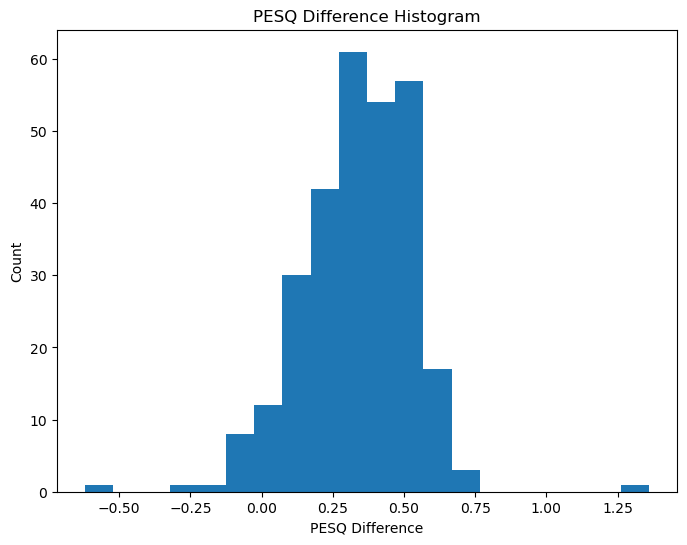

In [11]:
# Histogram of the difference in PESQ scores
plt.figure(figsize=(8, 6))
plt.hist(pesq_diff, bins=20)
plt.xlabel("PESQ Difference")
plt.ylabel("Count")
plt.title("PESQ Difference Histogram")
plt.show()

In [12]:
# Write the waveforms to .wav files
os.makedirs("results", exist_ok=True)

ind = np.where(pesq_diff == pesq_diff.max())[0][0]
sf.write("results/clean.wav", wav_clean_array[ind], samplerate=sr)
sf.write("results/corrupt.wav", wav_corrupt_array[ind], samplerate=sr)
sf.write("results/corrected.wav", wav_correct_array[ind], samplerate=sr)

In [13]:
# Listen to the waveforms
print(f"{Fore.LIGHTMAGENTA_EX}Clean Audio >> {Fore.RESET}")
display(Audio("results/clean.wav"))
print(f"{Fore.LIGHTCYAN_EX}Corrupted Audio >> {Fore.RESET}")
display(Audio("results/corrupt.wav"))
print(f"{Fore.LIGHTRED_EX}Corrected Audio >> {Fore.RESET}")
display(Audio("results/corrected.wav"))

Clean Audio >> 


Corrupted Audio >> 


Corrected Audio >> 


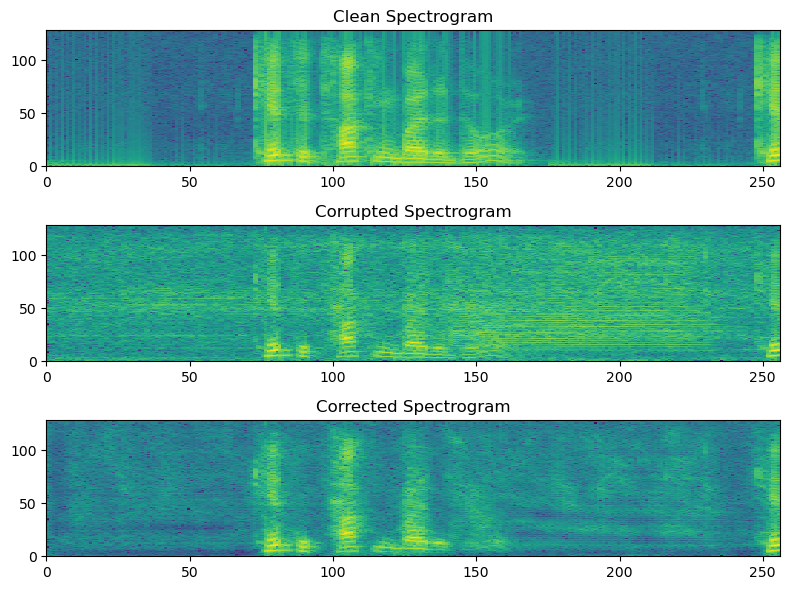

In [14]:
# Plot the spectrograms
plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plt.pcolormesh(np.log(spec_clean_array[ind]))
plt.title("Clean Spectrogram")
plt.subplot(3, 1, 2)
plt.pcolormesh(np.log(spec_corrupt_array[ind]))
plt.title("Corrupted Spectrogram")
plt.subplot(3, 1, 3)
plt.pcolormesh(np.log(spec_correct_array[ind]))
plt.title("Corrected Spectrogram")
plt.tight_layout()
plt.show()

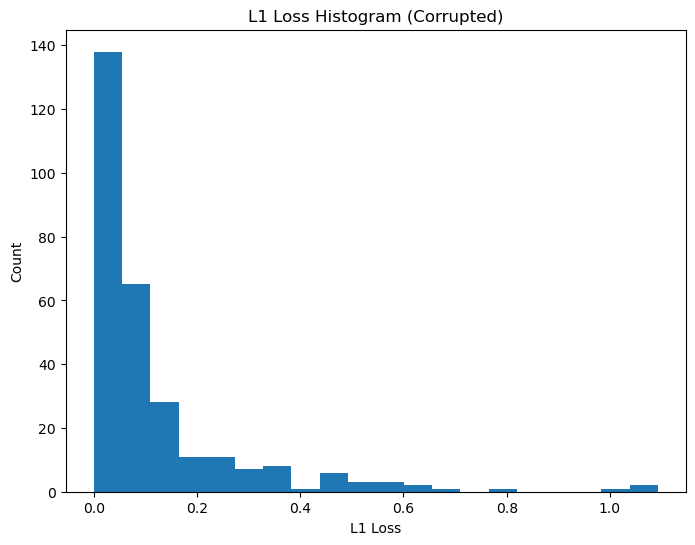

In [15]:
# Plot the loss histograms
plt.figure(figsize=(8, 6))
plt.hist(loss_with_noise, bins=20)
plt.xlabel("L1 Loss")
plt.ylabel("Count")
plt.title("L1 Loss Histogram (Corrupted)")
plt.show()

In [16]:
%%timeit -n 50
# Apply the model to the corrupted spectrogram
corrected_amp = model(torch.from_numpy(np.expand_dims(corr_amp, axis=0)))

16.7 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
